In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv("../data/processed/unsw_train_clean.csv")
df.head()

,timestamp,source,event_type,total_bytes,total_packets,raw_message,label
0,NaN,unsw,Normal,430,10,NaN,0
1,NaN,unsw,Normal,42748,52,NaN,0
2,NaN,unsw,Normal,13550,24,NaN,0
3,NaN,unsw,Normal,1398,24,NaN,0
4,NaN,unsw,Normal,802,16,NaN,0


In [3]:
df['event_type'] = df['event_type'].astype('category').cat.codes

In [4]:
features = ['total_bytes', 'total_packets', 'event_type']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

In [5]:
SEQ_LEN = 50  # you can tune this

def create_sequences(data, labels, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(labels[i+seq_len]) 
    return np.array(xs), np.array(ys)

X, y = create_sequences(df_scaled, df['label'].values, SEQ_LEN)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [7]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,913 (120.75 KB)

 Trainable params: 30,913 (120.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/5
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.8986 - loss: 0.2788 - val_accuracy: 0.8863 - val_loss: 0.2557
Epoch 2/5
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 51s 26ms/step - accuracy: 0.9532 - loss: 0.1484 - val_accuracy: 0.9551 - val_loss: 0.1254
Epoch 3/5
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - accuracy: 0.9539 - loss: 0.1311 - val_accuracy: 0.9552 - val_loss: 0.1203
Epoch 4/5
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 47s 24ms/step - accuracy: 0.9534 - loss: 0.1270 - val_accuracy: 0.9568 - val_loss: 0.1169
Epoch 5/5
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - accuracy: 0.9541 - loss: 0.1217 - val_accuracy: 0.9546 - val_loss: 0.1148


In [9]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     11136
           1       0.95      0.98      0.97     23923

    accuracy                           0.95     35059
   macro avg       0.96      0.94      0.95     35059
weighted avg       0.95      0.95      0.95     35059

[[ 9975  1161]
 [  427 23496]]


In [12]:
df['event_type'] = df['event_type'].astype('category').cat.codes

df['bytes_per_packet'] = df['total_bytes'] / (df['total_packets'] + 1)
df['log_total_bytes'] = np.log1p(df['total_bytes'])
df['log_total_packets'] = np.log1p(df['total_packets'])

features = [
    'total_bytes',
    'total_packets',
    'bytes_per_packet',
    'log_total_bytes',
    'log_total_packets',
    'event_type'
]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])


In [13]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

In [14]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),

    LSTM(32),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,513 (220.75 KB)

 Trainable params: 56,513 (220.75 KB)

 Non-trainable params: 0 (0.00 B)

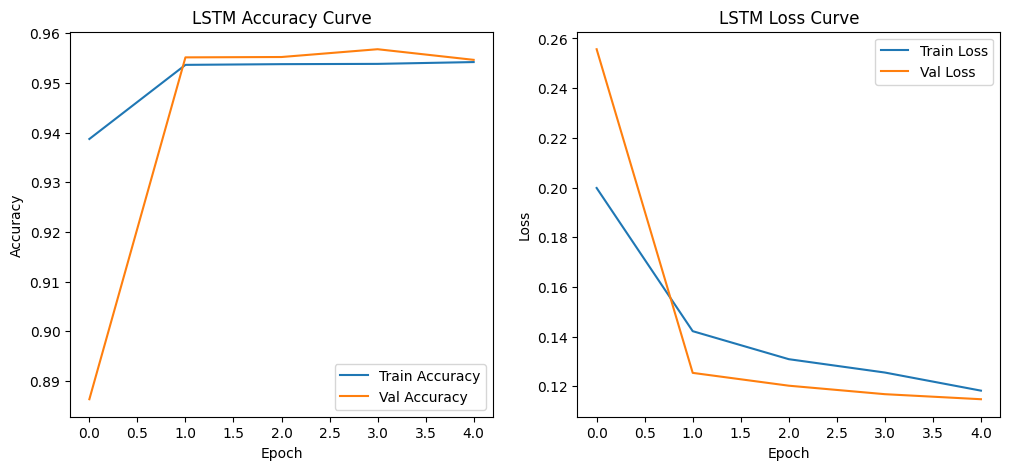

In [15]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

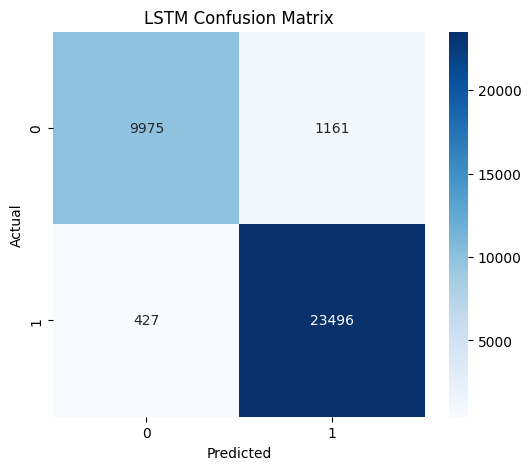

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     11136
           1       0.95      0.98      0.97     23923

    accuracy                           0.95     35059
   macro avg       0.96      0.94      0.95     35059
weighted avg       0.95      0.95      0.95     35059

